# 데이터 분석

1. `train, test 데이터의 Input 토큰 개수 분포 확인`
    - 전체 train, test 데이터에 대해 **샘플별 Input 토큰 개수** 확인
        - 최대 토큰 개수 (512)를 넘어가는 샘플 확인
    - 전체 train, test 데이터에 대해 **라벨의 Input 토큰 개수** 확인
    - 전체 train, test 데이터에 대해 **라벨별 Input 토큰 개수** 확인

<br/>

2. `train, dev 분리`
    - 효과적인 분리를 위한 아이디어
    - 8:2로 train, dev 분리 및 저장
    - `python train_dev_split.py` 를 통해 간단하게 train, dev 분리 가능하도록 구현 

<br/>

3. `분리된 train, dev Input 토큰 개수 분포 확인`
    - train, dev 데이터에 대해 **샘플별 Input 토큰 개수** 확인

## train, test데이터의 Input 토큰 개수 분포 확인

### 전체 train 데이터에 대해 샘플 별 Input 토큰 개수 확인

- BertTokenizer와 RobertaTokenizer일때 비교

In [84]:
from transformers import (BertTokenizer, RobertaTokenizer, LayoutLMTokenizer, LayoutLMv2Tokenizer, LayoutLMv3Tokenizer,
                          BERT_PRETRAINED_CONFIG_ARCHIVE_MAP,
                          LAYOUTLM_PRETRAINED_CONFIG_ARCHIVE_MAP,
                          ROBERTA_PRETRAINED_CONFIG_ARCHIVE_MAP,
                          LAYOUTLMV2_PRETRAINED_CONFIG_ARCHIVE_MAP,
                          LAYOUTLMV3_PRETRAINED_CONFIG_ARCHIVE_MAP,)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import unicodedata
from copy import deepcopy



MODEL_CLASSES = {
    "bert": BertTokenizer,
    "roberta": RobertaTokenizer,
    "layoutlm": LayoutLMTokenizer,
    "layoutlmv2" : LayoutLMv2Tokenizer,
    "layoutlmv3" : LayoutLMv3Tokenizer,
}

ALL_MODELS = sum(
    (
        tuple(conf_archive_map.keys())
        for conf_archive_map in (
            BERT_PRETRAINED_CONFIG_ARCHIVE_MAP,
            ROBERTA_PRETRAINED_CONFIG_ARCHIVE_MAP,
            LAYOUTLM_PRETRAINED_CONFIG_ARCHIVE_MAP,
            LAYOUTLMV2_PRETRAINED_CONFIG_ARCHIVE_MAP,
            LAYOUTLMV3_PRETRAINED_CONFIG_ARCHIVE_MAP,
        )
    ),
    (),
)

# Model you can use
list(ALL_MODELS)

['bert-base-uncased',
 'bert-large-uncased',
 'bert-base-cased',
 'bert-large-cased',
 'bert-base-multilingual-uncased',
 'bert-base-multilingual-cased',
 'bert-base-chinese',
 'bert-base-german-cased',
 'bert-large-uncased-whole-word-masking',
 'bert-large-cased-whole-word-masking',
 'bert-large-uncased-whole-word-masking-finetuned-squad',
 'bert-large-cased-whole-word-masking-finetuned-squad',
 'bert-base-cased-finetuned-mrpc',
 'bert-base-german-dbmdz-cased',
 'bert-base-german-dbmdz-uncased',
 'cl-tohoku/bert-base-japanese',
 'cl-tohoku/bert-base-japanese-whole-word-masking',
 'cl-tohoku/bert-base-japanese-char',
 'cl-tohoku/bert-base-japanese-char-whole-word-masking',
 'TurkuNLP/bert-base-finnish-cased-v1',
 'TurkuNLP/bert-base-finnish-uncased-v1',
 'wietsedv/bert-base-dutch-cased',
 'roberta-base',
 'roberta-large',
 'roberta-large-mnli',
 'distilroberta-base',
 'roberta-base-openai-detector',
 'roberta-large-openai-detector',
 'microsoft/layoutlm-base-uncased',
 'microsoft/layou

- `{}.txt` , `{}_box.txt`, `{}_image.txt` 가 주어지면 sample단위로 쪼개어 (샘플 리스트, 샘플 DataFrame) 반환

In [17]:
class InputExample(object):
    """A single training/test example for token classification."""

    def __init__(self, guid, words, labels, boxes, actual_bboxes, file_name, page_size):
        """Constructs a InputExample.

        Args:
            guid: Unique id for the example.
            words: list. The words of the sequence.
            labels: (Optional) list. The labels for each word of the sequence. This should be
            specified for train and dev examples, but not for test examples.
            boxes: (Optional) list. The bounding boxes of the words in the sequence.
            actual_bboxes: (Optional) list. The actual bounding boxes of the words in the sequence.
            file_name: (Optional) str. The name of the file.
            page_size: (Optional) list. The size of the page.
        """
        self.guid = guid
        self.words = words
        self.labels = labels
        self.boxes = boxes
        self.actual_bboxes = actual_bboxes
        self.file_name = file_name
        self.page_size = page_size


def read_examples_from_file(data_dir, mode): 
    file_path = os.path.join(data_dir, "{}.txt".format(mode))
    box_file_path = os.path.join(data_dir, "{}_box.txt".format(mode))
    image_file_path = os.path.join(data_dir, "{}_image.txt".format(mode))

    # make pd.DataFrame
    df = pd.DataFrame(columns=["text", "labels", "boxes", "actual_boxes", "file_name", "page_size"])
    guid_index = 1
    examples = []


    with open(file_path, encoding="utf-8") as f, open(
        box_file_path, encoding="utf-8"
    ) as fb, open(image_file_path, encoding="utf-8") as fi:
        words = []
        boxes = []
        actual_bboxes = []
        file_name = None
        page_size = None
        labels = []
        for line, bline, iline in zip(f, fb, fi):
            if line.startswith("-DOCSTART-") or line == "" or line == "\n":
                if words:
                    examples.append(
                        InputExample(
                            guid="{}-{}".format(mode, guid_index),
                            words=words,
                            labels=labels,
                            boxes=boxes,
                            actual_bboxes=actual_bboxes,
                            file_name=file_name,
                            page_size=page_size,
                        )
                    )
            
                    sample_df = pd.DataFrame.from_dict({"text": [words], "labels" : [labels], "boxes" : [boxes], "actual_boxes" : [actual_bboxes],"file_name" : [file_name], "page_size" : [page_size]})
                    df = pd.concat([df, sample_df], axis=0)

                    guid_index += 1
                    words = []
                    boxes = []
                    actual_bboxes = []
                    file_name = None
                    page_size = None
                    labels = []
            else:
                splits = line.split("\t")[:2] # [word, label]
                bsplits = bline.split("\t") # [word, box]
                isplits = iline.split("\t") # [word, actual_bbox, page_size, file_name]
                assert len(splits) == 2
                assert len(bsplits) == 2
                assert len(isplits) == 4
                assert splits[0] == bsplits[0]
                words.append(splits[0])
                if len(splits) > 1:
                    labels.append(splits[-1].replace("\n", ""))
                    box = bsplits[-1].replace("\n", "")
                    box = [int(b) for b in box.split()]
                    boxes.append(box)
                    actual_bbox = [int(b) for b in isplits[1].split()]
                    actual_bboxes.append(actual_bbox)
                    page_size = [int(i) for i in isplits[2].split()]
                    file_name = isplits[3].strip()
                else:
                    # Examples could have no label for mode = "test"
                    labels.append("O")
        if words: # if file does not end with a newline
            examples.append(
                InputExample(
                    guid="%s-%d".format(mode, guid_index),
                    words=words,
                    labels=labels,
                    boxes=boxes,
                    actual_bboxes=actual_bboxes,
                    file_name=file_name,
                    page_size=page_size,
                )
            )
    return examples, df.reset_index(drop=True)


def convert_to_uncased(sentence):
    """
    Convert a given sentence to uncased (lowercase) and remove accents.

    Args:
        sentence (str): The input sentence to convert.

    Returns:
        str: The sentence converted to lowercase and without accents.
    """
    # 소문자로 변환
    sentence = sentence.lower()
    
    # 악센트 제거
    normalized_sentence = unicodedata.normalize('NFKD', sentence)
    uncased_sentence = ''.join([c for c in normalized_sentence if not unicodedata.combining(c)])
    
    return uncased_sentence

In [99]:
_, train_df = read_examples_from_file("../data", "train")
_, test_df = read_examples_from_file("../data", "test")

In [4]:
train_df

,text,labels,boxes,actual_boxes,file_name,page_size
0,"[TAN, WOON, YANN, BOOK, TA, .K(TAMAN, DAYA), S...","[O, O, O, O, O, O, O, O, O, O, S-ADDRESS, S-AD...","[[155, 24, 280, 63], [291, 24, 460, 63], [470,...","[[72, 25, 130, 64], [135, 25, 213, 64], [218, ...",X00016469612,"[463, 1013]"
1,"[TAN, WOON, YANN, INDAH, GIFT, &, HOME, DECO, ...","[O, O, O, S-COMPANY, S-COMPANY, S-COMPANY, S-C...","[[173, 49, 302, 83], [314, 49, 487, 83], [498,...","[[76, 50, 133, 84], [138, 50, 214, 84], [219, ...",X00016469619,"[439, 1004]"
2,"[TAN, WOON, YANN, MR, D.T.Y., (JOHOR), SDN, BH...","[O, O, O, S-COMPANY, S-COMPANY, S-COMPANY, S-C...","[[259, 49, 383, 84], [394, 49, 559, 84], [570,...","[[119, 47, 176, 80], [181, 47, 257, 80], [262,...",X00016469620,"[459, 949]"
3,"[TAN, WOON, YANN, YONGFATT, ENTERPRISE, (JM051...","[O, O, O, S-COMPANY, S-COMPANY, O, S-ADDRESS, ...","[[208, 43, 336, 84], [347, 43, 518, 84], [529,...","[[96, 41, 155, 79], [160, 41, 239, 79], [244, ...",X00016469622,"[461, 933]"
4,"[TAN, WOON, YANN, MR, D.I.Y., (M), SDN, BHD, (...","[O, O, O, S-COMPANY, S-COMPANY, S-COMPANY, S-C...","[[179, 39, 302, 76], [313, 39, 477, 76], [488,...","[[83, 41, 140, 78], [145, 41, 221, 78], [226, ...",X00016469623,"[463, 1026]"
...,...,...,...,...,...,...
621,"[ONE, ONE, THREE, SEAFOOD, RESTAURANT, SDN, BH...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, S...","[[108, 192, 164, 215], [171, 192, 227, 215], [...","[[86, 329, 131, 368], [136, 329, 181, 368], [1...",X51008164997,"[795, 1705]"
622,"[ONE, ONE, THREE, SEAFOOD, RESTAURANT, SDN, BH...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, S...","[[109, 208, 166, 230], [172, 208, 229, 230], [...","[[87, 341, 132, 377], [137, 341, 182, 377], [1...",X51008164998,"[793, 1636]"
623,"[ONE, ONE, THREE, SEAFOOD, RESTAURANT, SDN, BH...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, S...","[[107, 172, 164, 187], [170, 172, 227, 187], [...","[[85, 334, 130, 363], [135, 334, 180, 363], [1...",X51008164999,"[791, 1932]"
624,"[3180303, GL, HANDICRAFT, &, TAIL, ORING, 19,,...","[O, S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY...","[[27, 30, 224, 47], [178, 149, 226, 168], [234...","[[16, 40, 131, 62], [104, 195, 132, 219], [137...",X51009453801,"[583, 1303]"


- Input 토큰 개수 확인

In [100]:
def input_length_analysis(model_type, model_name_or_path, train_df, test_df, dev_df=None, do_lowercase=True, mode='test', level ='sample'):
    """
    Tokenized text length analysis for each file in the dataset.
    
    Args:
        model_type: (str),  model type (e.g., 'bert', 'roberta', 'layoutlm')
        model_name_or_path: (str), model name or path
        train_df: (pd.DataFrame), train dataset
        test_df: (pd.DataFrame), test dataset
        dev_df: (pd.DataFrame), dev dataset
        do_lowercase: (bool), whether to lowercase the text
        mode: (str), mode of the dataset ('train', 'test', 'dev')
        level: (str), tokenized text length analysis level ('sample' or 'label')

    Returns:
        dfs.values(): (list), list of tokenized text length for each file
    """
    train_df, test_df = train_df.copy(), test_df.copy()

    # load tokenizer
    tokenizer = MODEL_CLASSES[model_type].from_pretrained(model_name_or_path, do_lower_case=do_lowercase)

    dfs = {'train': train_df, 'test': test_df, 'dev': dev_df}

    # concat all label text for each file
    if level == 'label':
        for key, value in dfs.items():
            if value is not None:
                value['text'] = value['text'].astype(str)
                dfs[key] = value.groupby('file_name').agg({'text': ' '.join}).reset_index()
    
    # Tokenize the label text
    for key, value in dfs.items():
        if value is not None:
            if model_type in ['layoutlmv3'] and do_lowercase:
                # convert to uncased (do_lower_case option does not work)
                dfs[key]['length'] = value['text'].apply(lambda x: len(tokenizer.tokenize(' '.join([convert_to_uncased(word) for word in x]))))
            else:
                dfs[key]['length'] = value['text'].apply(lambda x: len(tokenizer.tokenize(' '.join(x))))
    # Statistics of tokenized text length
    for key, value in dfs.items():
        if value is not None:
            print('[Statistics of tokenized {} text length by *{} tokenizer]'.format(level, model_type))
            print(' ({} set)'.format(key), ': Max length: {} |'.format(value['length'].max()), 'Mean length: {:.2f} |'.format(value['length'].mean()), 'Median length: {}'.format(value['length'].median()))
        

    # Plot the distribution of the tokenized text
    colors = ['blue', 'red', 'green']

    plt.figure(figsize=(8, 4))
    for idx, (key, value) in enumerate(dfs.items()):
        if value is not None:
            sns.histplot(value['length'], bins=50, color=colors[idx], kde=True, alpha=0.5, edgecolor='white')
    
    if mode=='test':
        plt.legend(['train', 'test'])
    else:
        
        plt.legend(['train', 'test', 'dev'])

    # Remove the top and right spines from plot
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.title('Tokenized {} text length distribution by *{} tokenizer'.format(level, model_type), fontsize=15)
    plt.xlabel('Tokenized {} text length'.format(level))
    plt.ylabel('Frequency')
    plt.show()

    return dfs.values()

[Statistics of tokenized sample text length by *bert tokenizer]
 (train set) : Max length: 569 | Mean length: 251.82 | Median length: 240.0
[Statistics of tokenized sample text length by *bert tokenizer]
 (test set) : Max length: 520 | Mean length: 249.17 | Median length: 235.0


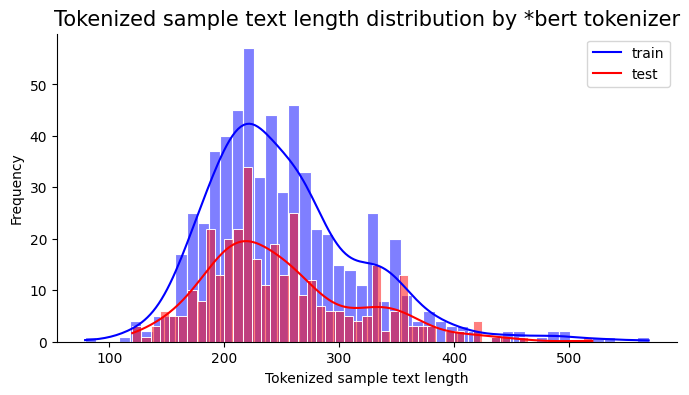

In [78]:
train_length_df, test_length_df, _,  = input_length_analysis('bert','google-bert/bert-base-uncased',train_df, test_df, level='sample')

[Statistics of tokenized sample text length by *layoutlm tokenizer]
 (train set) : Max length: 569 | Mean length: 251.82 | Median length: 240.0
[Statistics of tokenized sample text length by *layoutlm tokenizer]
 (test set) : Max length: 520 | Mean length: 249.17 | Median length: 235.0


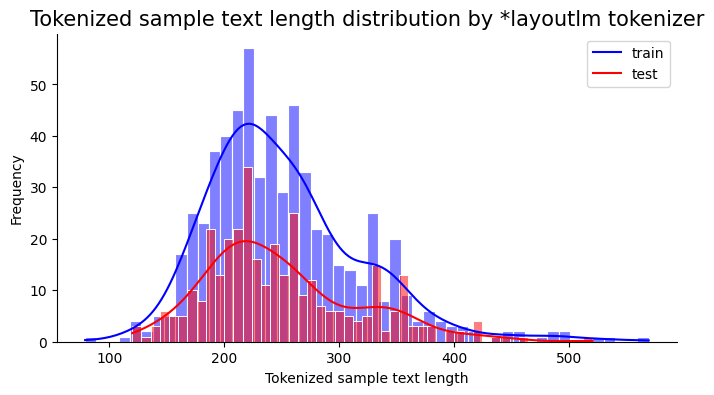

In [87]:
train_length_df, test_length_df, _,  = input_length_analysis('layoutlm','microsoft/layoutlm-base-uncased',train_df, test_df, level='sample')

[Statistics of tokenized sample text length by *layoutlmv2 tokenizer]
 (train set) : Max length: 569 | Mean length: 251.82 | Median length: 240.0
[Statistics of tokenized sample text length by *layoutlmv2 tokenizer]
 (test set) : Max length: 520 | Mean length: 249.17 | Median length: 235.0


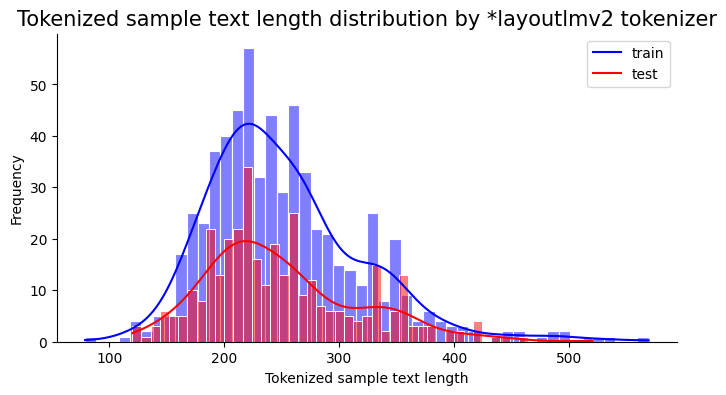

In [90]:
train_length_df, test_length_df, _,  = input_length_analysis('layoutlmv2','microsoft/layoutlmv2-base-uncased',train_df, test_df, level='sample')

[Statistics of tokenized sample text length by *layoutlmv3 tokenizer]
 (train set) : Max length: 624 | Mean length: 288.65 | Median length: 271.0
[Statistics of tokenized sample text length by *layoutlmv3 tokenizer]
 (test set) : Max length: 560 | Mean length: 286.20 | Median length: 270.0


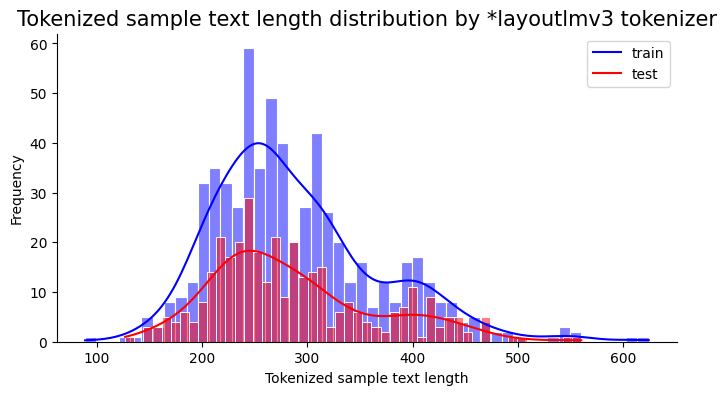

In [107]:
train_length_df, test_length_df, _,  = input_length_analysis('layoutlmv3','microsoft/layoutlmv3-base',train_df, test_df, do_lowercase=False,level='sample')

### 최대 토큰 개수 (512)를 넘어가는 샘플 확인

- 위 표는 train과 test 데이터의 샘플별 Input token 길이 분포입니다
- 사전학습된 모델의 최대 토큰 길이가 512이지만, 전반적으로 이 범위 안에 모두 들어오는 반면, 몇몇 512를 넘는 이상치들이 존재합니다
- 이 이상치이 무엇인지, 개수는 몇개인지 확인해보겠습니다

#### bert, layoutlm, layoutlmv2

In [233]:
train_length_df[train_length_df['length'] > 512]

,text,labels,boxes,actual_boxes,file_name,page_size,length
106,"[BEYOND, BROTHERS, HARDWARE, (872981-V), LOT, ...","[S-COMPANY, S-COMPANY, S-COMPANY, O, S-ADDRESS...","[[99, 73, 296, 89], [302, 73, 564, 89], [569, ...","[[93, 263, 278, 318], [283, 263, 529, 318], [5...",X51005663297,"[937, 3556]",533
311,"[AEON, CO., (M), BHD, (126926-H), 3RD, FLR,, A...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, O...","[[408, 47, 437, 60], [438, 47, 459, 60], [460,...","[[2020, 329, 2162, 423], [2167, 329, 2273, 423...",X51006414733,"[4945, 6981]",524
381,"[COSWAY, (M), SDN, BHD, (50118-A), 2ND, FLOOR,...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, O...","[[53, 89, 161, 103], [167, 89, 220, 103], [226...","[[47, 280, 142, 323], [147, 280, 194, 323], [1...",X51006619545,"[880, 3123]",569


In [234]:
test_length_df[test_length_df['length'] > 512]

,text,labels,boxes,actual_boxes,file_name,page_size,length
310,"[AEON, CO., (M), BHD, (126926-H), 3RD, FLR,, A...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, O...","[[358, 39, 387, 50], [388, 39, 410, 50], [411,...","[[1779, 275, 1923, 352], [1928, 275, 2036, 352...",X51007846283,"[4961, 7016]",520


- bert, layoutlm, layoutlmv2의 Tokenizer는 WordPiece이고, vocab도 동일합니다
- train의 이상치는 3개이며, 각각의 길이는 `533`, `524`, `569` 입니다
- test의 이상치는 1개이며, 길이는 `520` 입니다

- 이런 샘플들은 최대 길이 (512)만큼 truncation을 진행하여 입력으로 사용합니다
- 만약, 이때 truncation시에 버려지는 부분 안에 라벨 token이 존재한다면 모델은 이 token에 대해 정답을 예측해내지 못하게 됩니다

#### layoutlmv3

- layoutlmv3의 경우 uncased 모델이 존재하지 않습니다
- 그러므로, Roberta와 마찬가지로 do_lower_case=True를 지원하지 않습니다
- 이번 경우에는 uncased(소문자, 악센트 제거)로 만들어주는 함수를 이용해 do_lower_case 모드를 추가하였습니다

In [105]:
# do_lower_case = True
train_length_df[train_length_df['length'] > 512]

,text,labels,boxes,actual_boxes,file_name,page_size,length
106,"[BEYOND, BROTHERS, HARDWARE, (872981-V), LOT, ...","[S-COMPANY, S-COMPANY, S-COMPANY, O, S-ADDRESS...","[[99, 73, 296, 89], [302, 73, 564, 89], [569, ...","[[93, 263, 278, 318], [283, 263, 529, 318], [5...",X51005663297,"[937, 3556]",528
381,"[COSWAY, (M), SDN, BHD, (50118-A), 2ND, FLOOR,...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, O...","[[53, 89, 161, 103], [167, 89, 220, 103], [226...","[[47, 280, 142, 323], [147, 280, 194, 323], [1...",X51006619545,"[880, 3123]",540


- layoutlmv3의 Tokenizer는 BEP입니다
- `do_lower_case = True`
- train의 이상치는 2개이며 각각의 길이는 `528`, `540` 입니다
- 이런 샘플들은 최대 길이(512) 만큼 truncation을 진행하여 입력으로 사용합니다

In [108]:
# do_lower_case = False
train_length_df[train_length_df['length'] > 512]

,text,labels,boxes,actual_boxes,file_name,page_size,length
34,"[PERNIAGAAN, ZHENG, HUI, JM0325955-V, NO.59, J...","[S-COMPANY, S-COMPANY, S-COMPANY, O, S-ADDRESS...","[[386, 113, 499, 128], [503, 113, 560, 128], [...","[[417, 173, 539, 196], [544, 173, 605, 196], [...",X51005433533,"[1080, 1527]",548
106,"[BEYOND, BROTHERS, HARDWARE, (872981-V), LOT, ...","[S-COMPANY, S-COMPANY, S-COMPANY, O, S-ADDRESS...","[[99, 73, 296, 89], [302, 73, 564, 89], [569, ...","[[93, 263, 278, 318], [283, 263, 529, 318], [5...",X51005663297,"[937, 3556]",603
134,"[MYDIN, TRI, SHAAS, SDN, BHD, (728515-M), MYDI...","[O, S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY...","[[242, 88, 633, 121], [170, 122, 226, 141], [2...","[[216, 255, 565, 351], [152, 355, 202, 411], [...",X51005705760,"[892, 2897]",556
311,"[AEON, CO., (M), BHD, (126926-H), 3RD, FLR,, A...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, O...","[[408, 47, 437, 60], [438, 47, 459, 60], [460,...","[[2020, 329, 2162, 423], [2167, 329, 2273, 423...",X51006414733,"[4945, 6981]",556
381,"[COSWAY, (M), SDN, BHD, (50118-A), 2ND, FLOOR,...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, O...","[[53, 89, 161, 103], [167, 89, 220, 103], [226...","[[47, 280, 142, 323], [147, 280, 194, 323], [1...",X51006619545,"[880, 3123]",624
397,"[ECOSWAY.COM, SDN, BHD, (509213A), 2ND, FLOOR,...","[S-COMPANY, S-COMPANY, S-COMPANY, O, S-ADDRESS...","[[82, 100, 315, 113], [321, 100, 385, 113], [3...","[[73, 291, 278, 328], [283, 291, 339, 328], [3...",X51006619785,"[880, 2900]",547
427,"[AEON, CO., (M), BHD, (126926-H), 3RD, FLR,, A...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, O...","[[307, 64, 336, 77], [337, 64, 359, 77], [360,...","[[1527, 454, 1671, 543], [1676, 454, 1784, 543...",X51006913019,"[4961, 7016]",529
525,"[AEON, CO., (M), BHD, (126926-H), 3RD, FLR,, A...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, O...","[[390, 51, 419, 65], [420, 51, 442, 65], [443,...","[[1938, 364, 2082, 457], [2087, 364, 2195, 457...",X51007846305,"[4961, 7016]",541


In [109]:
# do_lower_case = False
test_length_df[test_length_df['length'] > 512]

,text,labels,boxes,actual_boxes,file_name,page_size,length
40,"[POPULAR, BOOK, CO., (M), SDN, BHD, (CO., NO.,...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, S...","[[179, 49, 505, 69], [510, 49, 696, 69], [134,...","[[168, 175, 473, 246], [478, 175, 652, 246], [...",X51005568855,"[936, 3521]",549
310,"[AEON, CO., (M), BHD, (126926-H), 3RD, FLR,, A...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, O...","[[358, 39, 387, 50], [388, 39, 410, 50], [411,...","[[1779, 275, 1923, 352], [1928, 275, 2036, 352...",X51007846283,"[4961, 7016]",560


- `do_lower_case = False`
- train의 이상치는 8개이며 각각의 길이는 `548`, `603`, `556`, `556`, `624`, `547`, `529`, `541` 입니다
- test의 이상치는 2개이며 각각의 길이는 `549`, `560` 입니다
- 이런 샘플들은 최대 길이(512) 만큼 truncation을 진행하여 입력으로 사용합니다

### 전체 train, test 데이터에 대해 **라벨의 Input 토큰 개수** 확인

In [124]:
train_df, test_df = pd.read_csv("train.csv"), pd.read_csv("test.csv") # train.csv and test.csv are the csv files from analysis_bboxes.ipynb

[Statistics of tokenized label text length by *bert tokenizer]
 (train set) : Max length: 68 | Mean length: 41.95 | Median length: 41.0
[Statistics of tokenized label text length by *bert tokenizer]
 (test set) : Max length: 61 | Mean length: 40.83 | Median length: 40.0


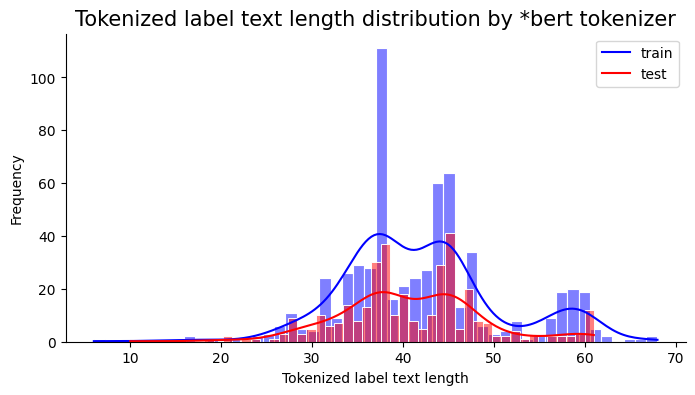

In [125]:
_, _, _,  = input_length_analysis('bert','google-bert/bert-base-uncased',train_df, test_df, level='label')

[Statistics of tokenized label text length by *roberta tokenizer]
 (train set) : Max length: 89 | Mean length: 53.26 | Median length: 54.0
[Statistics of tokenized label text length by *roberta tokenizer]
 (test set) : Max length: 79 | Mean length: 52.23 | Median length: 52.0


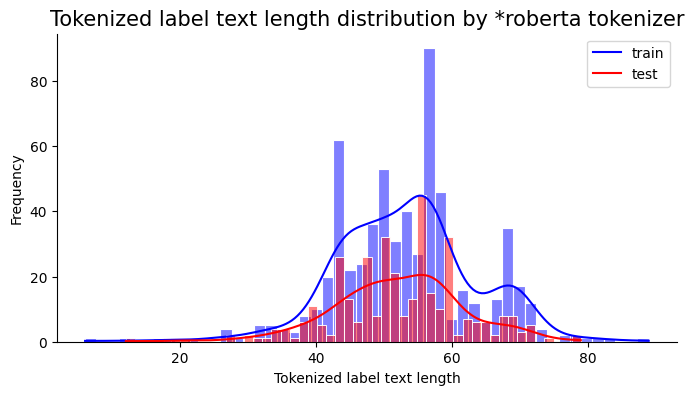

In [126]:
_, _, _ = input_length_analysis('roberta','FacebookAI/roberta-large',train_df, test_df, level='label')

### 전체 train, test 데이터에 대해 **라벨별 Input 토큰 개수** 확인

In [129]:
#전체 train, test 데이터에 대해 라벨별 Input 토큰 개수 확인
def input_length_analysis_per_label(model_type,model_name_or_path,train_df, test_df,do_lowercase=True, mode='test'):
    """
    Tokenized text length analysis for each label in the dataset.
    
    Args:
        model_type: (str),  model type (e.g., 'bert', 'roberta', 'layoutlm')
        model_name_or_path: (str), model name or path
        train_df: (pd.DataFrame), train dataset
        test_df: (pd.DataFrame), test dataset
        do_lowercase: (bool), whether to lowercase the text
        mode: (str), mode of the dataset ('train', 'test', 'dev')
        
    Returns:
        train_text_len_series: (pd.Series), tokenized text length for each label in train dataset
        test_text_len_series: (pd.Series), tokenized text length for each label in test dataset
    """

    # load tokenizer
    tokenizer = MODEL_CLASSES[model_type].from_pretrained(model_name_or_path, do_lower_case=do_lowercase)

    train_df['text'] = train_df['text'].astype(str)
    test_df['text'] = test_df['text'].astype(str)

    label_dict = {'company':0, 'address':1, 'date':2, 'total':3}
    
    # Tokenize the text
    for key in label_dict:
        train_text_len_series = train_df[train_df['label']==key]['text'].apply(lambda x: len(tokenizer.tokenize(x) if type(x) is str else []))
        test_text_len_series = test_df[test_df['label']==key]['text'].apply(lambda x: len(tokenizer.tokenize(x) if type(x) is str else []))
        label_dict[key] = (train_text_len_series, test_text_len_series)
    

    # Calculate statistics
    for key in label_dict:
        print('[Statistics of tokenized "{}" text length by *{} tokenizer]'.format(key, model_type))
        print(' (Train set)', ': Max length: {} |'.format(label_dict[key][0].max()), 'Mean length: {:.2f} |'.format(label_dict[key][0].mean()), 'Median length: {}'.format(label_dict[key][0].median()))
        print(' (Test set) ', ': Max length: {} |'.format(label_dict[key][1].max()), 'Mean length: {:.2f} |'.format(label_dict[key][1].mean()), 'Median length: {}'.format(label_dict[key][1].median()), '\n')


    # Plot the distribution of the tokenized text by label using subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    for i, key in enumerate(label_dict):
        row = i // 2
        col = i % 2

        sns.histplot(label_dict[key][0], bins=50, color='blue', kde=True, alpha=0.5, edgecolor='white', ax=axes[row, col])
        sns.histplot(label_dict[key][1], bins=50, color='red', kde=True, alpha=0.5, edgecolor='white', ax=axes[row, col])

        if mode=='test':
            axes[row, col].legend(['train', 'test'])
        else:
            axes[row, col].legend(['train', 'dev'])

        # Remove the top and right spines from plot
        axes[row, col].spines['top'].set_visible(False)
        axes[row, col].spines['right'].set_visible(False)

        axes[row, col].set_title('Tokenized [{}] text length distribution by *{} tokenizer'.format(key, model_type), fontsize=13)
        axes[row, col].set_xlabel('Tokenized text length')
        axes[row, col].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    return train_text_len_series, test_text_len_series

[Statistics of tokenized "company" text length by *bert tokenizer]
 (Train set) : Max length: 17 | Mean length: 8.40 | Median length: 9.0
 (Test set)  : Max length: 19 | Mean length: 8.22 | Median length: 8.0 

[Statistics of tokenized "address" text length by *bert tokenizer]
 (Train set) : Max length: 46 | Mean length: 25.47 | Median length: 25.0
 (Test set)  : Max length: 42 | Mean length: 24.70 | Median length: 25.0 

[Statistics of tokenized "date" text length by *bert tokenizer]
 (Train set) : Max length: 10 | Mean length: 4.84 | Median length: 5.0
 (Test set)  : Max length: 6 | Mean length: 4.68 | Median length: 5.0 

[Statistics of tokenized "total" text length by *bert tokenizer]
 (Train set) : Max length: 6 | Mean length: 3.19 | Median length: 3.0
 (Test set)  : Max length: 5 | Mean length: 3.23 | Median length: 3.0 



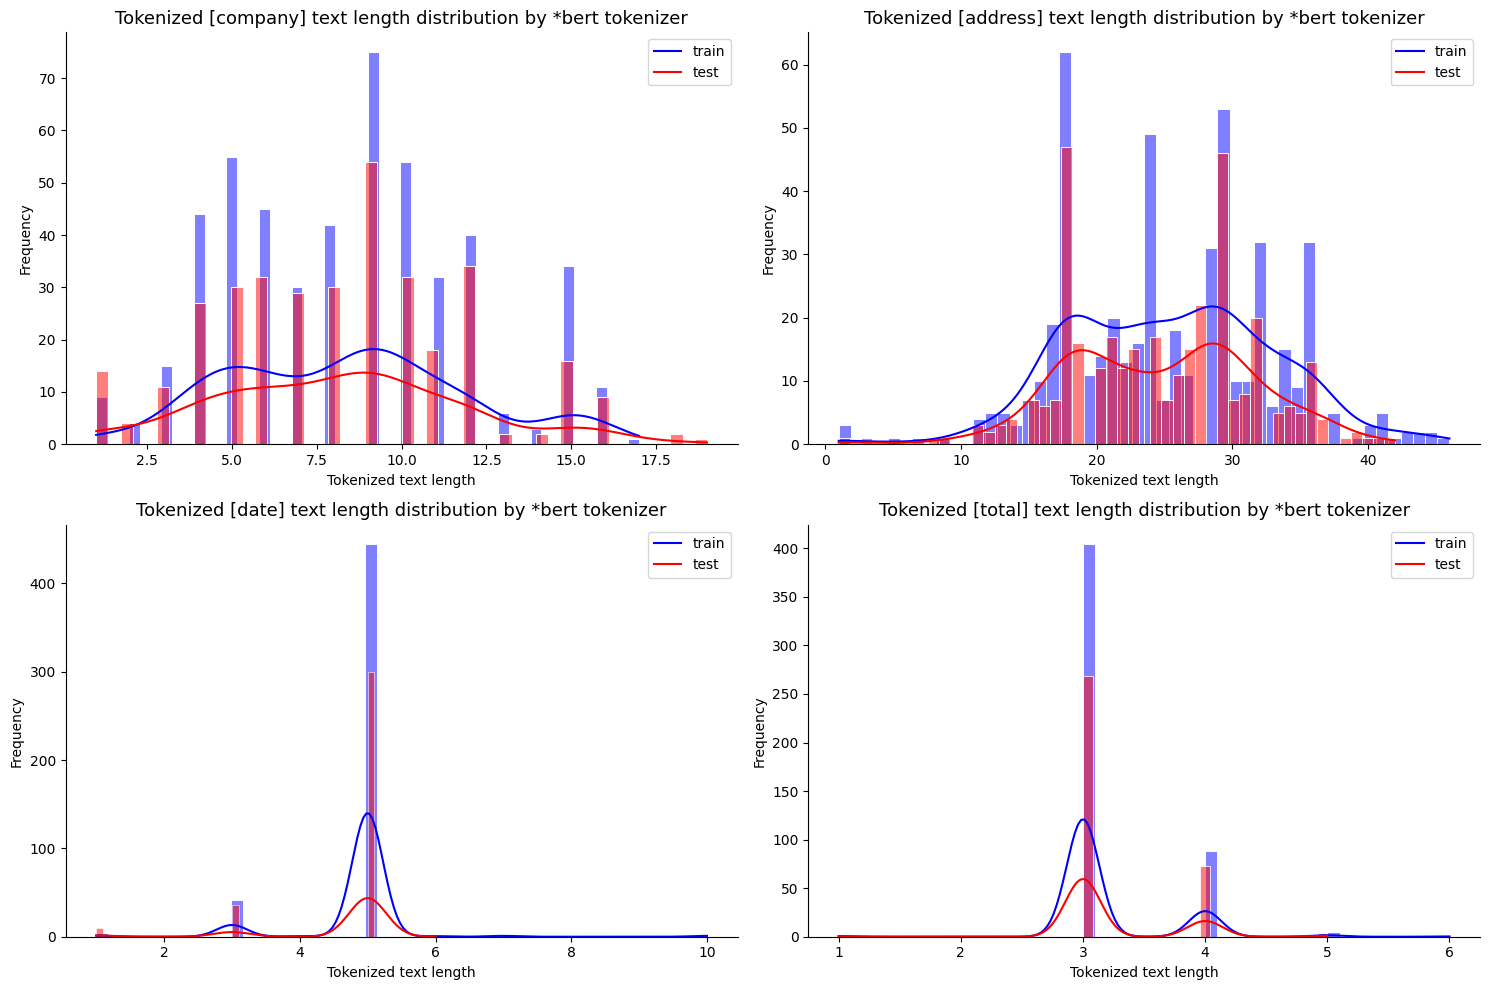

In [130]:
_, _ = input_length_analysis_per_label('bert','google-bert/bert-base-uncased',train_df, test_df)

[Statistics of tokenized "company" text length by *roberta tokenizer]
 (Train set) : Max length: 24 | Mean length: 11.32 | Median length: 11.0
 (Test set)  : Max length: 25 | Mean length: 11.14 | Median length: 11.0 

[Statistics of tokenized "address" text length by *roberta tokenizer]
 (Train set) : Max length: 66 | Mean length: 34.21 | Median length: 34.0
 (Test set)  : Max length: 60 | Mean length: 33.45 | Median length: 33.0 

[Statistics of tokenized "date" text length by *roberta tokenizer]
 (Train set) : Max length: 10 | Mean length: 4.88 | Median length: 5.0
 (Test set)  : Max length: 6 | Mean length: 4.75 | Median length: 5.0 

[Statistics of tokenized "total" text length by *roberta tokenizer]
 (Train set) : Max length: 6 | Mean length: 3.16 | Median length: 3.0
 (Test set)  : Max length: 4 | Mean length: 3.20 | Median length: 3.0 



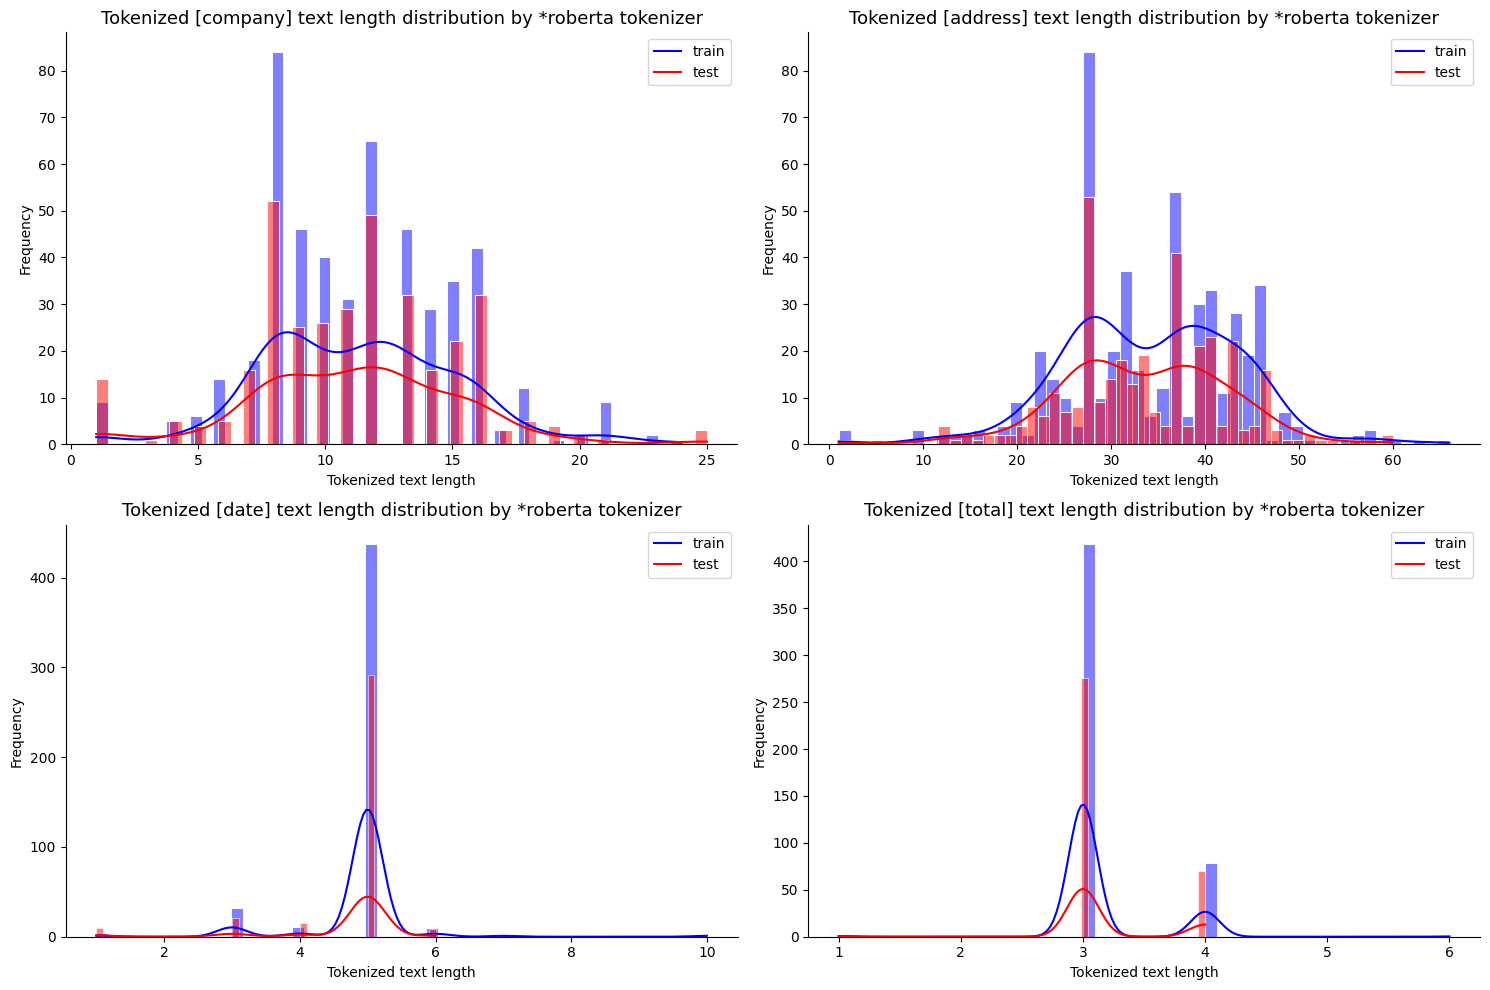

In [131]:
_, _ = input_length_analysis_per_label('roberta','FacebookAI/roberta-large',train_df, test_df)

## train, dev 분리

### 효과적인 분리를 위한 아이디어

- `Dev와 Test의 분포가 같아야 한다`\
    → Dev와 Test의 라벨별 Input 토큰 개수 분포가 비슷하도록 구성\
    → 현재 Train과 Test의 분포가 비슷한 것을 확인\
    → 랜덤 샘플링으로 train, dev 분리

- `적절한 Dev 크기`\
    → train 데이터 개수(626)가 작아 검증의 신뢰성을 높이기 위해 train:dev 비율을 [9:1]이 아닌 [8:2]로 선정
    
- `모델 배포 이후 적용되는 현실의 데이터와 Dev, Test 데이터의 분포가 같아야 한다`\
    → 지금 해결할 수 있는 문제가 아님

- `python train_dev_split.py` 를 통해 간단하게 train, dev 분리 가능하도록 구현 
    
    - layoutlmV2를 사용함에 따라 `train_dev_split.py`를 통해 이미지들도 train, dev 분리되어 저장되도록 기능 추가

In [6]:
train_examples, _ = read_examples_from_file("../data", "train")

### train, dev [8:2] 랜덤 샘플링

In [7]:
# shuffle
random.seed(42)
print("Number of training examples:", len(train_examples))
#
train_size = int(0.8 * len(train_examples))
train_set = random.sample(train_examples, train_size)

# # split train and validation 8:2
val_set = [item for item in train_examples if item not in train_set]

print("Number of training set:", len(train_set))
print("Number of validation set:", len(val_set))

Number of training examples: 626
Number of training set: 500
Number of validation set: 126


In [55]:
# make new_train.txt, new_train_box.txt, new_train_image.txt and dev.txt, dev_box.txt, dev_image.txt
def write_examples_to_file(examples, mode):
    with open(f"{mode}.txt", "w", encoding="utf-8") as f, open(
        f"{mode}_box.txt", "w", encoding="utf-8"
    ) as fb, open(f"{mode}_image.txt", "w", encoding="utf-8") as fi:
        for example in examples:
            for word, label, box, actual_bbox in zip(
                example.words, example.labels, example.boxes, example.actual_bboxes
            ):
                f.write(f"{word}\t{label}\n")
                fb.write(f"{word}\t{' '.join([str(b) for b in box])}\n")
                fi.write(
                    f"{word}\t{' '.join([str(b) for b in actual_bbox])}\t{' '.join([str(i) for i in example.page_size])}\t{example.file_name}\n"
                )
            f.write("\n")
            fb.write("\n")
            fi.write("\n")

In [56]:
write_examples_to_file(train_set, "new_train")
write_examples_to_file(val_set, "dev")

## 분리된 train, dev, test Input 토큰 개수 분포 확인

### train, dev, test 데이터에 대해 샘플별 Input 토큰 개수 확인

- train과 dev DataFrame 분할 후, 샘플별 Input 토큰 개수 확인

In [66]:
_, train_df = read_examples_from_file("./", "new_train")
_, dev_df = read_examples_from_file("./", "dev")
_, test_df = read_examples_from_file("../data", "test")

[Statistics of tokenized sample text length by *bert tokenizer]
 (train set) : Max length: 569 | Mean length: 252.21 | Median length: 241.0
[Statistics of tokenized sample text length by *bert tokenizer]
 (test set) : Max length: 520 | Mean length: 249.17 | Median length: 235.0
[Statistics of tokenized sample text length by *bert tokenizer]
 (dev set) : Max length: 477 | Mean length: 250.28 | Median length: 236.0


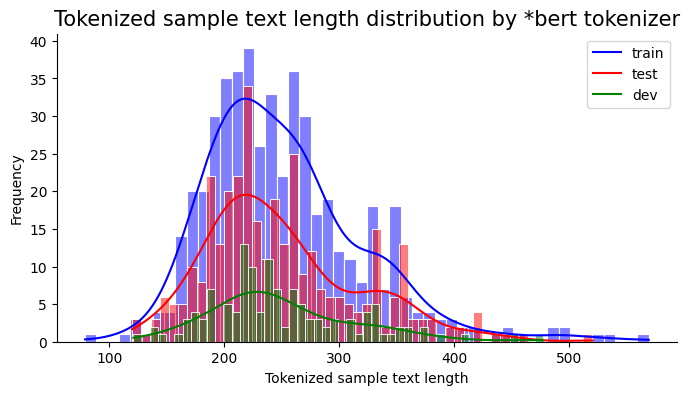

In [60]:
_, _, _ = input_length_analysis('bert','google-bert/bert-base-uncased',train_df, test_df, dev_df, mode='dev', level='sample')

In [67]:
# error analysis를 위한 csv 파일 저장
dev_df.to_csv("dev.csv", index=False)

### 이미지 파일 분할

In [11]:
_, train_df = read_examples_from_file("../input/data", "train")
_, dev_df = read_examples_from_file("../input/data", "dev")

In [13]:
# ../input/data에 존재하는 train/img 폴더에 있는 이미지 파일들 중에서, dev_df의 file_name에 해당하는 이미지 파일들을 dev/img 폴더로 이동
import shutil
import os

assert len(dev_df["file_name"].unique()) == 126

if not os.path.exists(f"../input/data/dev/img"):
        os.makedirs(f"../input/data/dev/img/")

for file_name in dev_df["file_name"].unique():
    shutil.move(f"../input/data/train/img/{file_name}", f"../input/data/dev/img/{file_name}")

,text,labels,boxes,actual_boxes,file_name,page_size
0,"[SYL, ROASTED, DELIGHTS, SDN., BHD., 1227039, ...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, S...","[[101, 270, 179, 294], [187, 270, 370, 294], [...","[[63, 340, 112, 369], [117, 340, 231, 369], [2...",X51005337872,"[623, 1255]"
1,"[GARDENIA, BAKERIES, (KL), SDN, BHD, (139386, ...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, S...","[[54, 60, 230, 80], [238, 60, 414, 80], [422, ...","[[34, 72, 143, 96], [148, 72, 257, 96], [262, ...",X51006555817,"[620, 1200]"
2,"[POPULAR, BOOK, CO., (M), SDN, BHD, (CO., NO.,...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, S...","[[193, 46, 522, 70], [529, 46, 717, 70], [153,...","[[144, 102, 389, 154], [394, 102, 534, 154], [...",X51006008089,"[744, 2177]"
3,"[UNIHAKKA, INTERNATIONAL, SDN, BHD, 03, APR, 2...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, S...","[[369, 244, 441, 254], [442, 244, 558, 254], [...","[[1834, 1713, 2190, 1786], [2195, 1713, 2773, ...",X51006414431,"[4961, 7016]"
4,"[AEON, CO., (M), BHD, (126926-H), 3RD, FLR,, A...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, O...","[[264, 69, 345, 91], [352, 69, 412, 91], [419,...","[[187, 114, 244, 150], [249, 114, 291, 150], [...",X51005757235,"[706, 1640]"
...,...,...,...,...,...,...
121,"[TAN, WOON, YANN, INDAH, GIFT, &, HOME, DECO, ...","[O, O, O, S-COMPANY, S-COMPANY, S-COMPANY, S-C...","[[173, 49, 302, 83], [314, 49, 487, 83], [498,...","[[76, 50, 133, 84], [138, 50, 214, 84], [219, ...",X00016469619,"[439, 1004]"
122,"[GARDENIA, BAKERIES, (KL), SDN, BHD, (139386, ...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, S...","[[61, 58, 235, 79], [243, 58, 417, 79], [425, ...","[[38, 74, 146, 101], [151, 74, 259, 101], [264...",X51006557198,"[620, 1264]"
123,"[GARDENIA, BAKERIES, (KL), SDN, BHD, (139386, ...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, S...","[[60, 54, 235, 74], [243, 54, 418, 74], [426, ...","[[37, 67, 145, 91], [150, 67, 258, 91], [263, ...",X51006557508,"[616, 1224]"
124,"[UNIHAKKA, INTERNATIONAL, SDN, BHD, 21, MAR, 2...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, S...","[[347, 227, 417, 238], [422, 227, 537, 238], [...","[[375, 348, 451, 365], [456, 348, 580, 365], [...",X51005442386,"[1080, 1528]"
